In [1]:
# setup
library(reshape2)
library(magrittr)
library(dplyr)
library(ggplot2)
library(viridis)

DATA.DIR = '../data/'

tellme = function(x){
    read.csv(paste0(DATA.DIR,'/police_stop_data_dictionary.csv')) %>%
        filter(Column.Name==x) %>%
        select(Description) %>%
        return
}

app.key.list = function(n){
    key = paste0('rpt',as.character(n))
    data %>% select(starts_with(key)) %>% names %>% return
}



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: viridisLite


## Introduction
May 1, 2019 [Boulder PD released a (cleaned and processed) dataset](https://www.denverpost.com/2019/05/01/people-of-color-arrests-boulder-police-stop/) containing data on all *discretionary* stops made by Boulder police in 2018. Discretionary stops make up only a fraction of Boulder police activity, with the vast majority of police interactions being *non-discretionary*, eg. where an officer was dispatched based on a 911 call. Approximately 66,400 police interactions are non-discretionary (per an in-person workshop on the data organized by the City of Boulder on May 6, 2019), whereas 8,209 are discretionary. 

The data were compiled on the recommendation of the consulting firm Hillard Heintz, who in 2016 were hired to perform an internal study of arrest and citation activity within Boulder PD. The [official report](https://bouldercolorado.gov/police/stop-data-information) released by the city has a few high-level takeaways:
1. The report represents only a single year of data and "cannot yet be put into context" (ie. trending up or down)
2. Small data sizes mean that small changes in stop or citation number may have meaningful effects in data trends
3. Laws and policies regulating discretionary action can have "significant positive effects", but will require coordinated action
4. Racial differences in stop rates differ by base population. Black residents are overstopped relative to the population, but this is not the case for black non-residents.

This data suggests that racial bias is likely occurring in the discretionary stops of Boulder police. We see that black individuals are over-represented in the stop dataset, relative to the demographic baselines provided in the official border report (what I will call the "top-level stop rates"). I break down the stop data in a number of ways which highlight some of the reasons why this bias occurs in the top-level. I find, for example, that black individuals who have been stopped are more likely to be considered "suspicious", and that black individuals who are searched for contraband are less likely to have it than their white counterparts. My results are not strictly limited to white or black individuals, however due to small sample sizes other races it is hard to draw conclusions about bias towards eg. Indigenous Americans.  

In this report I examine open data on discretionary police stops made by the Boulder Police Deptartment in 2018. My goal is to determine if the data exhibits evidence of racial bias in stop activity, and if so to break it down across activity types.

### About the Data
The original data is broken into two files: `police_stop_data_main_2018.csv` and `police_stop_data_results_2018.csv`. The first dataset contains a row for every individual discretionary stop made by Boulder PD. Let's see what columns the data includes:

In [2]:
'police_stop_data_main_2018.csv' %>% paste0(DATA.DIR,.) %>% read.csv %>% names %>% print

 [1] "stopdate"      "stoptime"      "streetnbr"     "streetdir"    
 [5] "street"        "Min"           "sex"           "race"         
 [9] "ethnic"        "Year.of.birth" "enfaction"     "rpmainid"     


We see columns for stop date, time, and duration (in minutes), as well as for race, ethnicity, and sex of the stopped individual **as percieved by the reporting officer**. We also have columns `enfaction`, which indicates if the stopped individual was a resident of Boulder or not, and an `rpmainid`, which links each row to data in the second dataset.

The structure of `police_stop_data_results_2018.csv` is slightly more complex. This file contains information on the stops listed in the `main` dataset, as well as any potential outcomes of each. Let's see what columns it has:

In [3]:
'police_stop_data_results_2018.csv' %>% paste0(DATA.DIR,.) %>% read.csv %>% names %>% print

[1] "appkey"   "appid"    "itemcode" "itemdesc" "addtime" 


The `appid` column is used to link rows in `results` to rows in `main` (through the `rpmainid` column in `main`). A big difference here is that each value of `rpmainid` appears only once in `main`, whereas a single `appid` might be listed in multiple rows in `results`, corresponding to multiple outcomes of the same stop. The `appkey` column contains one of seven different values, 'RPT1' through 'RPT7', which indicate what kind of information is contained in the row:

| Appkey | Data              |
|--------|-------------------|
| RPT1   | Stop type         |
| RPT2   | Stop reason       |
| RPT3   | Search conducted  |
| RPT4   |  Search authority |
| RPT5   |  Contraband found |
| RPT6   | Result of stop    |
| RPT7   |  Charge issued    |


The corresponding info is then stored in `itemdesc`. Each pair of `appid` and `appkey` might be listed in multiple rows, eg. if there's more than one reason for the stop. This is not a very convenient data stucture. It would be far better if all of the information was present in a single dataset, and if each row corresponded to exactly one stop (ie. if the data was "tidy"). Fortunately my friend [Sam](https://github.com/samzhang111) has gone ahead and [tidied]() the data. This basically swings the each `appkey`/`infodesc` pair out into its own column. For example, if a row has an `appkey` of "rpt1" and an `infodesc` of "pedestrian" that gets converted into a "1" under the column `rpt1.pedestrian`. Let's see what this looks like...

In [4]:
dat = read.csv(paste0(DATA.DIR,'tidy.csv')) %>% set_colnames(tolower(names(.)))
dat %<>% mutate(raceethn=ifelse(ethnic=='H',race%>%paste0('H'), race%>%as.character))
dat %>% names %>% print

 [1] "stopdate"                            "stoptime"                           
 [3] "streetnbr"                           "streetdir"                          
 [5] "street"                              "min"                                
 [7] "sex"                                 "race"                               
 [9] "ethnic"                              "year.of.birth"                      
[11] "enfaction"                           "rpmainid"                           
[13] "raceethn"                            "rpt1.pedestrian"                    
[15] "rpt1.vehicle"                        "rpt2.disturbance"                   
[17] "rpt2.equipment.violation"            "rpt2.municipal.violation"           
[19] "rpt2.noise.violation"                "rpt2.right.of.way.violation"        
[21] "rpt2.speeding"                       "rpt2.state.violation"               
[23] "rpt2.suspicious"                     "rpt2.traffic.parking.violation"     
[25] "rpt2.traffic.reckless.

### Analysis Methodology
In this analysis we're going to want to estimate the probability that certain things occur, eg. "what's the probability that a stop occurred because someone was 'suspicious'?". I'm going to estimate these probabilities using the Bayesian methodology. The basic approach here is to find a probability distribution *over probabilities*. That is, given some set binary yes/no observations, we're going to construct what's called the "posterior distribution" over possible values of the probability of a "yes". Let's define some helper functions to do this. I'm going to skip explaining how these functions work in detail (see the bottom of the page for a deeper explanation), but the basic upshot is that they output a probability density function (pdf) which has high density over probability values that are consistent with the observed data. 

In [47]:
# posterior distribution given binomial likelihood and beta prior                              
binom.posterior = function(q, outcome_vec, pr.alpha=1, pr.beta=1){
    q %>% qbeta(pr.alpha + sum(outcome_vec), pr.beta + length(outcome_vec) - sum(outcome_vec)) %>%
        return
}

binom.posterior.pdf = function(p, outcome_vec, pr.alpha=1, pr.beta=1){
    p %>% dbeta(pr.alpha + sum(outcome_vec), pr.beta + length(outcome_vec) - sum(outcome_vec)) %>%
        return
}


binom.posterior.exp.var = function(outcome_vec,pr.alpha=1,pr.beta=0){
    a = pr.alpha + sum(outcome_vec)
    b = pr.beta + length(outcome_vec) - sum(outcome_vec)
    mean = a/(a+b)
    var = (a*b)/((a+b+1)*(a+b)^2)
    return(list('mean'=mean,'var'=var))
}


plot.posterior = function(post,race.cutoff=100){    
    q = c(.1,.25,.50,.75,.9)
    plot.df = sapply(dat %>%
                    group_by(raceethn) %>%
                    filter(n()>race.cutoff) %>% as.data.frame %>%
                    select(raceethn) %>%
                    unique %>% unlist,
                    function(r){q %>% post(r)}) %>% as.data.frame
    
    plot.df$q = q
    plot.df %<>%  melt('q') %>% set_colnames(c('q','race','quantiles')) %>% dcast(race ~ q ) 
    plot.df %<>% set_colnames(c('race','y0','y25','y50','y75','y100'))
    plot.df$x = as.numeric(plot.df$race)
    p = ggplot( plot.df, aes(x=x,group=as.factor(race), color=as.factor(race)) ) +
        geom_boxplot( aes(ymin = y0, 
                          lower = y25, 
                          middle = y50, 
                          upper = y75, 
                          ymax = y100), stat = "identity") +
        xlab(expression('p'[r])) + ylab('Posterior Density')
    p %>% return
}

plot.posterior.pdf = function(post,low.bd=0,up.bd=1,race.cutoff=100){
    x = seq(low.bd,up.bd,.001)
    plot.df = sapply(dat %>%
                     group_by(raceethn) %>%
                     filter(n()>race.cutoff) %>% as.data.frame %>%
                     select(raceethn) %>%
                     unique %>% .[,1],
                     function(r){x %>% post(r)}) %>% as.data.frame

    plot.df$x = x
    plot.df = plot.df %>% melt('x') %>% set_colnames(c('x','race','post'))
    p = ggplot( plot.df, aes(x=x, y=post, color=as.factor(race), group=race) ) +
        geom_line() +
        xlab(expression('p'[r])) + ylab('Posterior Density')
    p %>% return
}


## Getting into it
A key challenge in assessing bias in top-level stop rates is the so-called "denominator problem": if X% of individuals stopped were of race R we typically want to know whether this number reflects the underlying demographics of the policed population. If race R is Y% of the population and Y << X then this indicates that race R is being over-policed, or vice versa. The City of Boulder did a lot of work estimating demographic information about the policed population of Boulder, which includes residents, students, people experiencing homelessness, and non-residents who commute for work. A closer look at this work can be found in their [2018 Annual Report](https://bouldercolorado.gov/police/stop-data-information). For our purposes we're just going to pull their population totals and demographic breakdown information and enter it manually.

In [48]:
pop.totals = c(106271,34510,21001,1960)
white.percent = c(.879,.659,.687,.631)
black.percent = c(.011,.025,.027,.074)
asian.percent = c(.053,.078,.039,.006)
indig.percent = c(.003,.016,.009,.028)

demography.df = data.frame(race=c('white'))

race.totals = c(sum(white.percent*pop.totals),
                sum(indig.percent*pop.totals),
                sum(black.percent*pop.totals),
                sum(asian.percent*pop.totals)
    ) %>% rev
race.percent = round(race.totals/sum(race.totals),2)

To measure top level stop rates by race we can simply count the number of occurences of each race in the `race` column of the tidied data (recall that each row of the tidied data corresponds to a single unique stop). Note that a single individual may have been stopped multiple time, and in that case would appear as two or more rows in the tidied data.

In [7]:
stop.breakdown = dat %>% filter(race=='W'|race=='B'|race=='A'|race=='I') %>%
group_by(race) %>% 
summarize(Stops=n(),
          Percent=round(n()/nrow(dat),2)) %>%
mutate('Pop Percent'=race.percent, 
       'Pop Total'=race.totals)
stop.breakdown

race,Stops,Percent,Pop Percent,Pop Total
A,310,0.04,0.06,9154.942
B,353,0.04,0.02,2743.798
I,36,0.00,0.01,1114.862
W,7425,0.90,0.91,131818.746


So it looks like there's some mismatch between stop rates and demographic representation. But just from this table it's not clear if these differences are meaninful, or if they just represent noise. We can use the Bayesian approach to address this. By plotting the posterior density over the probability of being in the stop dataset by race we can get a sense of whether these differences are meaningful. 

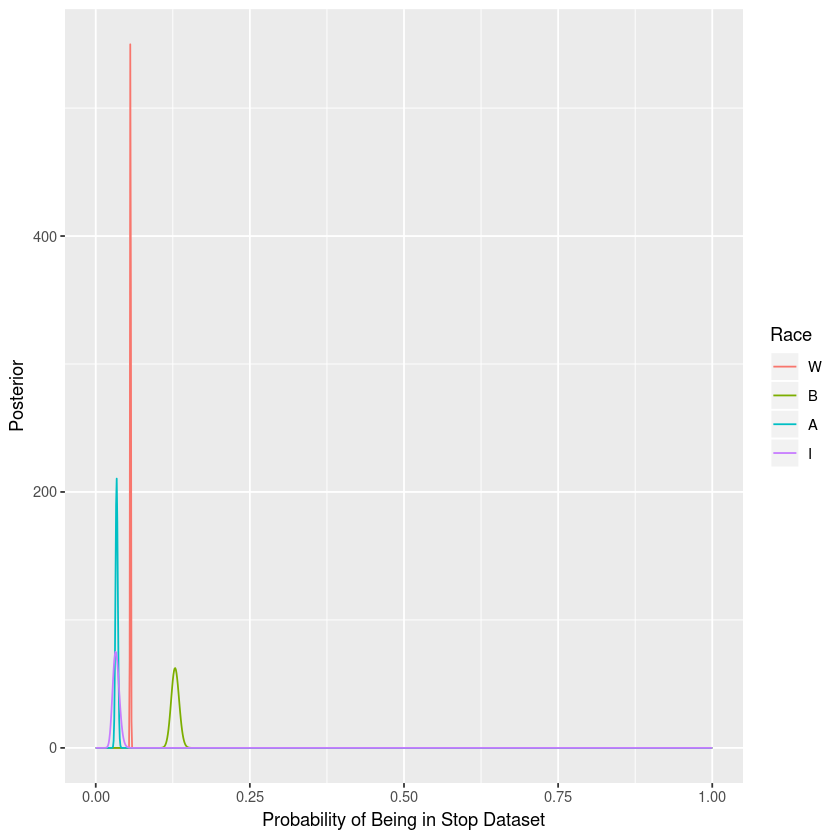

In [49]:
top.stop.posterior = function(x,r){
    n = stop.breakdown %>% filter(race==r) %>% 
    select('Pop Total') %>% unlist %>% as.numeric
    
    stopped = stop.breakdown %>% filter(race==r) %>% 
    select(Stops) %>% unlist %>% as.numeric
    
    a = 1 + stopped
    b = 1 + n - stopped

    return( dbeta(x,a,b) )    

}

x = seq(0,1,.001)
w = top.stop.posterior(x,'W')
plot.df = data.frame('x'=x,
                    'W'=top.stop.posterior(x,'W'),
                    'B'=top.stop.posterior(x,'B'),
                    'A'=top.stop.posterior(x,'A'),
                    'I'=top.stop.posterior(x,'I')                    
                    ) %>% melt(id.vars=c('x')) %>% set_colnames(c('x','Race','Posterior'))
p = ggplot(plot.df,aes(x=x,y=Posterior,group=Race,color=Race)) + geom_line() + xlab('Probability of Being in Stop Dataset')
p

Since the posterior densities exhibit substantial amounts of separation it's pretty clear that there are racial differences between the probabilities of experiencing a discretionary stop. Asian and indigenous individuals seem to have similar, low probability of being stopped, relative to white individuals. On the other hand, black individuals are *substantially* more likely to be included in this data, and there appears to be almost no overlap with the other posterior densities. This is pretty clear evidence that race has some kind of effect on police stop rates. Let's dig in on why this might be the case.

### Who's deemed suspicious?
The first thing we might look at to explain these racialized differences is "RPT2: Stop Reason". Let's see what kind of reasons Boulder police list for discretionary stops...

In [50]:
'police_stop_data_results_2018.csv' %>% paste0(DATA.DIR,.) %>% 
read.csv %>% filter(appkey=='RPT2')  %>% group_by(itemdesc) %>% summarize(count=n()) %>%
set_colnames(c('Stop Reason','Number of Stops'))

Stop Reason,Number of Stops
DISTURBANCE,35
EQUIPMENT VIOLATION,933
MUNICIPAL VIOLATION,2237
NOISE VIOLATION,10
RIGHT OF WAY VIOLATION,3
SPEEDING,1
STATE VIOLATION,222
SUSPICIOUS,284
TRAFFIC-PARKING VIOLATION,18
TRAFFIC-RECKLESS/CARELESS,668


So a sizeable number of the stops were because the stopping officer was "suspicious" of the stopped individual (284 of them). For anyone who's even vaguely paying attention this will probably set off alarm bells, as "suspicious" can be a highly racialized descriptor in this context. Let's break down "suspicious" stop counts by race and see if there's any bias at work.

In [51]:
dat %>% group_by(raceethn) %>% 
summarize(sum(rpt2.suspicious),n()) %>%
set_colnames(c('Race','a','b')) %>%
mutate(test=round(a/b,2)) %>%
set_colnames(c('Race','# Suspicious Stops','Total Stops','Percentage')) %>%
arrange(Percentage)

Race,# Suspicious Stops,Total Stops,Percentage
,0,72,0.00
H,0,1,0.00
IH,0,1,0.00
U,0,10,0.00
A,6,310,0.02
W,224,6762,0.03
WH,31,663,0.05
B,21,353,0.06
I,2,35,0.06


As suspected, there appear to be some racial differences in the composition of stop reasons. Race codes `B` and `I` especially seem to have a higher percentage of "suspicious" stops than `W` or `A`. Let's use the Bayesian approach to be more rigorous about this. We'd like to estimate the probability that, given someone of race $r$ was stopped in the first place, that they were stopped because they were  "suspicious". We'll denote this probability $p_r$. A subtle but important point here (that you may have guessed from the awkward wording in the definition of $p_r$) is that $p_r$ is *not* the same as "the probability that someone of race $r$ was deemed suspicious", which I will denote $\pi_r$. Rewriting the definition of these two quantities using more formal probability notation can help make this difference apparent:
$$
\begin{split}
p_r &= \text{Pr}[\text{suspicious}=1 | \text{race}=r, \text{stopped}=1]\\
\pi_r &= \text{Pr}[\text{suspicious}=1|\text{race}=r] \\
\end{split}
$$

Clearly these are different quantities, although they are related in the following way:
$$
\begin{split}
\text{Pr}[\text{suspicious}=1|\text{race}=r] = &\text{Pr}[\text{suspicious}=1|\text{race}=r, \text{stopped}=0]\text{Pr}[\text{stopped}=0|\text{race}=r] +\\
&\text{Pr}[\text{suspicious}=1|\text{race}=r, \text{stopped}=1]\text{Pr}[\text{stopped}=1|\text{race}=r]\\
\end{split}
$$
That is to say, $\pi_r$ is the result of marginalizing over the `stopped` random variable. Since this dataset by definition only contains data where $\text{stopped}=1$, we have no information about what happens when $\text{stopped}=0$. This means that while this analysis may show serious differences in $p_r$ by race, those differences may disappear or reverse if we're talking about the more general quantity $\pi_r$. However for these differences to reverse it would require $\text{Pr}[\text{stopped}=1|\text{race}=r]$ to be small, relative to $\text{Pr}[\text{suspicious}=1|\text{race}=r, \text{stopped}=0]\text{Pr}[\text{stopped}=0|\text{race}=r]$, and in my opinion we really don't have reason to suspect that this is the case. 

With that caveat out of the way, let's look at the posterior density:

Using quantiles as value column: use value.var to override.


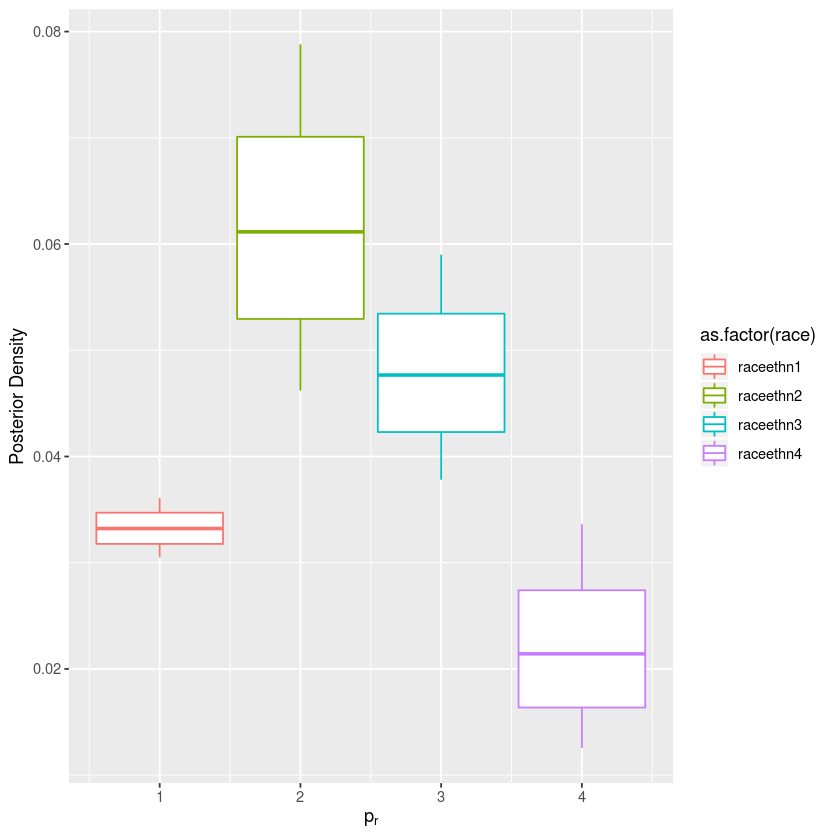

In [52]:
prob.susp.by.race = function(x,r){ dat %>%
                                       filter(raceethn==r) %>%
                                       select(rpt2.suspicious) %>%
                                       as.matrix %>%
                                       binom.posterior(x,.) %>%
                                       return }

plot.posterior(prob.susp.by.race)

### Given someone is searched, what's the probability that they have contraband?
A common counterpoint to analyses like the above is that racial differences in stop rates may reflect racial differences in the underlying crime rates, rather than racism. One way that we can test this is performing what's called an outcome test. This idea originated in the economics literature to test loan officers were discriminating against black applicants. The idea there was to look at whether blacks individuals who *did* recieve home loans defaulted at a lower rate than their white counterparts. If this is the case (and it was), then it indicated that the loan officers were holding black applicants to a higher standard than white applicants. We can apply a similar logic here, and look at the rates at which police searches turn up contraband. If black individuals who are searched are *less* likely to have contraband than white individuals who are searched, then it suggests that police are searching black individuals with a lower threshold of evidence, ie. that racial animus is probably a factor in their decision to search. Let's plot the posterior density over the probability that, given someone is searched, the search turns up contraband:

Using quantiles as value column: use value.var to override.


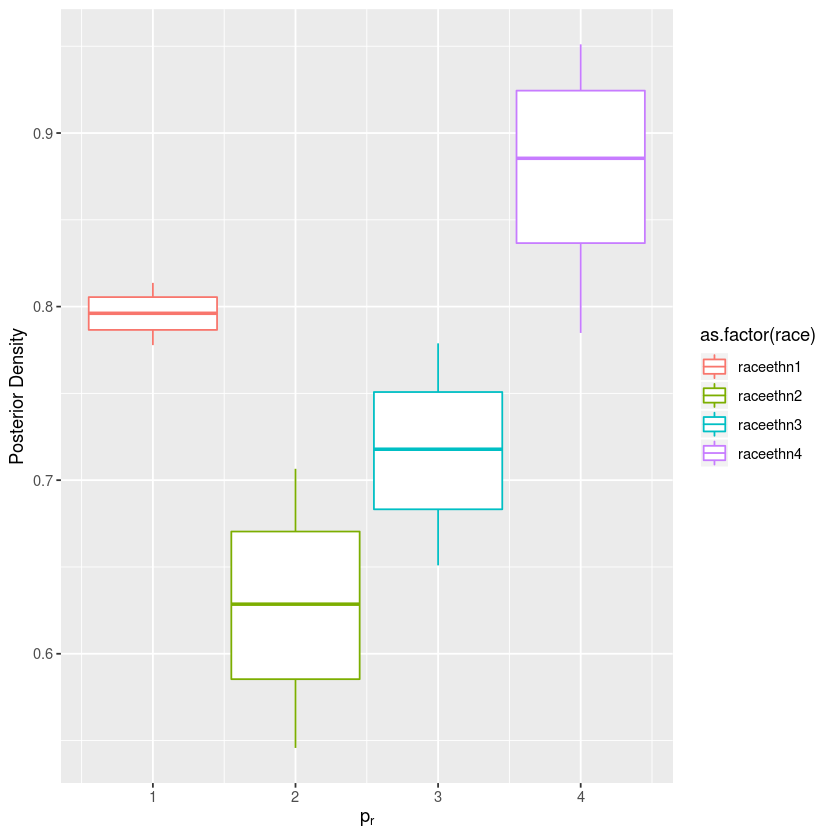

In [53]:
prob.cont.given.searched = function(x,r){ dat %>%
                                            mutate(rpt3.search=not(rpt3.no.search|rpt3..no.search) ) %>%
                                            filter(raceethn==r & rpt3.search==1) %>%
                                            select(rpt5.nothing.seized) %>%
                                            as.matrix %>% `!` %>%
                                            binom.posterior(x,.) %>%
                                            return }

prob.cont.given.searched.resident = function(x,r){ dat %>%
                                            mutate(rpt3.search=not(rpt3.no.search|rpt3..no.search) ) %>%
                                            filter(raceethn==r & rpt3.search==1 & enfaction=='Y') %>%
                                            select(rpt5.nothing.seized) %>%
                                            as.matrix %>% `!` %>%
                                            binom.posterior(x,.) %>%
                                            return }

prob.cont.given.searched.nonresident = function(x,r){ dat %>%
                                            mutate(rpt3.search=not(rpt3.no.search|rpt3..no.search) ) %>%
                                            filter(raceethn==r & rpt3.search==1 & enfaction=='N') %>%
                                            select(rpt5.nothing.seized) %>%
                                            as.matrix %>% `!` %>%
                                            binom.posterior(x,.) %>%
                                            return }

plot.posterior(prob.cont.given.searched)


### Most racialized search reason?
Repeat "prob searched because suspicious" analysis for each `RPT2` `itemdesc`. Calculate pairwise TV distance between posteriors of all races, and then average. Look for `itemdesc` with highest average TV distance.

TV distance is hard to calculate, and I can't find exact formulae for beta distributions. Instead gonna use the Hellinger distance $H(P,Q)$ instead (which has a known expression for betas). Then $H^2(P,Q) \leq TV(P,Q) \leq \sqrt{2} H(P,Q)$, so gonna use the lower bound as a sub for TV

In [174]:
dist.hellinger = function(outcome1,outcome2,pr.alpha=1,pr.beta=1){
    a1 = 1 + sum(outcome1)
    a2 = 1 + sum(outcome2)
    b1 = 1 + length(outcome1) - sum(outcome1)
    b2 = 1 + length(outcome2) - sum(outcome2)
    
    if (beta(a1,b1)*beta(a2,b2) == 0){return(1)} 
    else {}
    ret = 1 - beta( (a1+a2)/2, (b1+b2)/2 )/sqrt( beta(a1,b1) * beta(a2,b2) )
    return(ret)
}

dist.tv = function(outcome1,outcome2){
    p = seq(0,1,.05)
    pdf1 = binom.posterior.pdf(p, outcome1)
    pdf2 = binom.posterior.pdf(p, outcome2)
    
    pdf1 = pdf1/sum(pdf1)
    pdf2 = pdf2/sum(pdf2)
    
    diff.pdf = abs(pdf1 - pdf2)
    
    tv = -Inf
    for (n in 1:length(diff.pdf)){
        for( A in combn(diff.pdf,n) ){
            msr=sum(A)
            if (tv < msr){tv=msr}
            else {}
            
        }
    }
    
    tv %>% return
}

dist.bf = function(outcome1,outcome2){
    mod1.a1 = 1 + sum(outcome1)
    mod1.b1 = 1 + length(outcome1) - sum(outcome1)
    mod1.a2 = 1 + sum(outcome2)
    mod1.b2 = 1 + length(outcome2) - sum(outcome2)
    
    mod1.prD = choose(length(outcome1),sum(outcome1))*beta(mod1.a1,mod1.b1)*
            choose(length(outcome2),sum(outcome2))*beta(mod1.a2,mod1.b2)   
    
    outcome = c(outcome1,outcome2) 
    mod2.a = 1 + sum(outcome)
    mod2.b = 1 + length(outcome) - sum(outcome)
    
    mod2.prD = choose(length(outcome),sum(outcome))*beta(mod2.a,mod2.b) 

    return(mod1.prD/mod2.prD)       
}


pairwise.distance.comp = function(itemdesc, race.cutoff=400){ 
    races = dat %>% group_by(raceethn) %>% filter(n()>race.cutoff) %>% as.data.frame %>%
    select(raceethn) %>% unique %>% .[,1]
    races = c('W','B','WH','A','I')
    comp.pairs = expand.grid(races,races)
    
    hdists = c()
    for (i in 1:length(races)){
            for (j in i:length(races)){
                if (i==j){next}
                race1 = races[i]
                race2 = races[j]
                outcome1 = dat %>% filter(raceethn==race1) %>% select(itemdesc) %>% unlist
                outcome2 = dat %>% filter(raceethn==race2) %>% select(itemdesc) %>% unlist
    
                hdists %<>% append( posterior.bf(outcome1,outcome2) )
            }
        }    
    hdists %>% mean %>% return    
}

ln.beta.approx = function(a,b){
    ret = log(beta(a,b))
    if (abs(ret)<Inf){
        return(ret)
    }
    
    ret = .5*log(2*pi) + (a-.5)*log(a) + (b-.5)*log(b) - (a+b-.5)*log(a+b)
    
}

ln.binom.approx = function(n,k){
    ret = log(choose(n,k))
    
    if (ret<Inf){ return(ret) }
    
    ret = .5*log(n) - .5*log(2*pi*k*(n-k)) + n*log(n) - k*log(k) - (n-k)*log(n-k)
    return(ret)
}

full.bf.comp = function(itemdesc, race.cutoff=100){ 
    races = dat %>% group_by(raceethn) %>% filter(n()>race.cutoff) %>% as.data.frame %>%
    select(raceethn) %>% unique %>% unlist
    races = c('W','B')

    numer.terms = c()
    for (i in 1:length(races)){
        race = races[i]
        outcome = dat[dat$raceethn==race,] %>% select(itemdesc) %>% unlist        
        a = 1 + sum(outcome)
        b = 1 + length(outcome) - sum(outcome)

        numer.terms %<>% append(ln.beta.approx(a,b) + ln.binom.approx(length(outcome),sum(outcome)))
    }
    mod1.ln.prD = sum(numer.terms)
    
    outcome = dat %>% select(itemdesc) %>% unlist
    a = 1 + sum(outcome)
    b = 1 + length(outcome) - sum(outcome)
    mod2.ln.prD = ln.beta.approx(a,b) + ln.binom.approx(length(outcome),sum(outcome))
    
    return(mod1.ln.prD - mod2.ln.prD)
}



foo = dat %>% select(starts_with('rpt2')) %>% names# %>% sapply(full.bf.comp)
#bar = data.frame('reason' = (dat %>% select(starts_with('rpt2')) %>% names),
#           'racialization'=(foo %>% as.numeric %>%round(2))) %>% arrange(-racialization)
#bar$reason %<>% as.character
#for (i in 1:nrow(bar)){
#    reason = strsplit(bar$reason[i],'.',fixed=TRUE)[[1]][-1]
#    bar$reason[i] = paste(reason,collapse='.')   
#}
#print(bar)
full.bf.comp(foo[4])
full.bf.comp(foo[2])

[1] -5.675654

[1] -5.675654

#### Do equipment violations end with more bad outcomes for PoC?

In [24]:
dat %>% group_by(raceethn) %>% filter(rpt2.equipment.violation==1) %>% 
summarize(sum(rpt6.arrest),n()) %>% set_colnames(c('c','a','b')) %>%
mutate(perc=round(a/b,2)) %>% set_colnames(c('Race','Arrested','Total Counts','Percentage'))

dat %>% group_by(raceethn) %>% filter(rpt2.equipment.violation==1) %>% 
summarize(n()-sum(rpt3..no.search)+sum(rpt3.no.search),n()) %>% set_colnames(c('c','a','b')) %>%
mutate(perc=round(a/b,2)) %>% set_colnames(c('Race','Searched','Total Counts','Percentage'))

Race,Arrested,Total Counts,Percentage
,1,9,0.11
A,1,31,0.03
B,1,38,0.03
I,0,4,0.00
U,0,4,0.00
W,16,785,0.02
WH,3,62,0.05


Race,Searched,Total Counts,Percentage
,2,9,0.22
A,4,31,0.13
B,4,38,0.11
I,0,4,0.00
U,0,4,0.00
W,119,785,0.15
WH,7,62,0.11


Using quantiles as value column: use value.var to override.


Using quantiles as value column: use value.var to override.


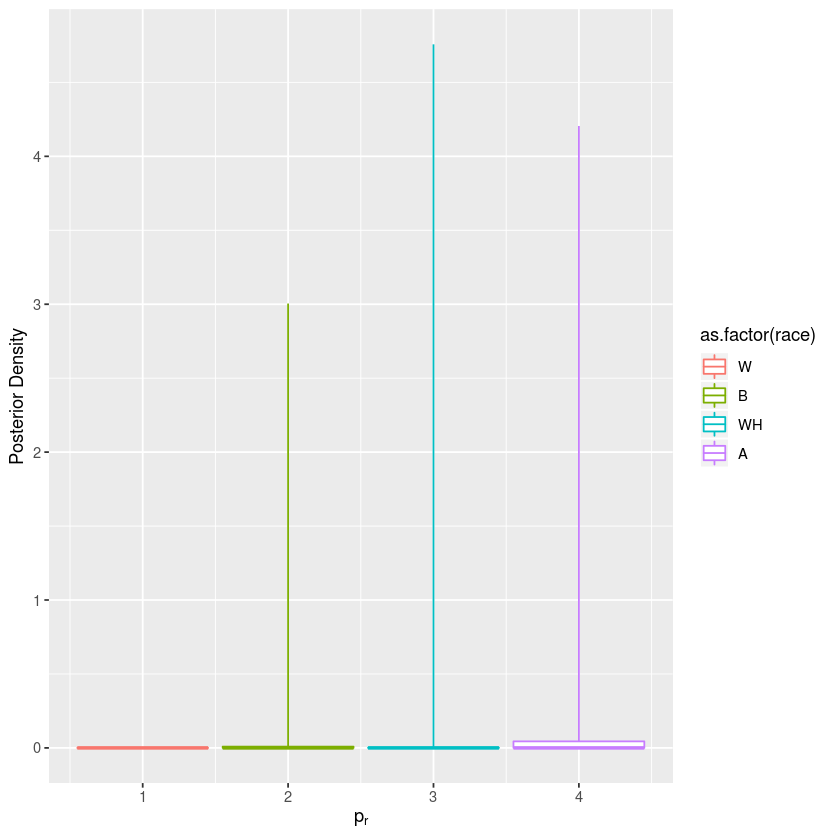

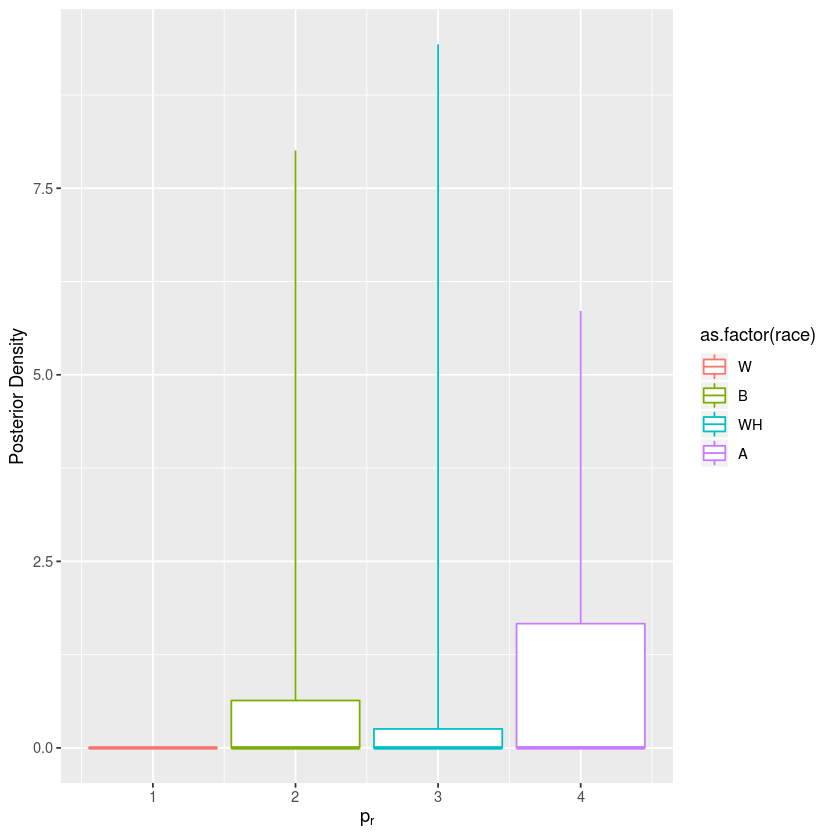

In [26]:
prob.arrested.given.equip.viol = function(x,r){ dat %>%
                                           filter(raceethn==r & rpt2.equipment.violation==1) %>%
                                           select(rpt6.arrest) %>%
                                           as.matrix %>%
                                           unif.beta.updated(x,.) %>%
                                           return }

prob.searched.given.equip.viol = function(x,r){ dat %>%
                                               filter(raceethn==r & rpt2.equipment.violation==1) %>%
                                               mutate(rpt3.search=not(rpt3.no.search|rpt3..no.search) ) %>%
                                               select(rpt3.search) %>%
                                               as.matrix %>%
                                               unif.beta.updated(x,.) %>%
                                               return }


plot.posterior(prob.arrested.given.equip.viol)
plot.posterior(prob.searched.given.equip.viol)

### Basic Bayesian Analysis 
#### Probability Notation
$\text{Pr}[Y=x]$ is "the probability that random variable Y takes value x"
$\text{Pr}[Y]$ is an abbreviation of the above, where $x$ is implied to be variable ie. the probability density function
$\text{Pr}[Y=x|A=b]$ is "the probabilty that random variable $Y=x$ given that $A=b$"

#### Binomial Random Variable
One of the first problems to be addressed using the Bayesian methodology was estimating the "probability" parameter of a binomial random variable. Say that a random variable $X$ takes values in $\{0,1\}$, with $\text{Pr}[X=1] = \pi$. Say that we observe $n$ such draws of $X$, which we will denote $X_1=X_1,...,X_n=x_n$. The probability of this sequence of observations is:
$$
\text{Pr}[X_1=x_1,...,X_n=x_n|\pi=p] = S_n^p (n-s_n)^{1-p}
$$
Where $s_n = \sum_i^n x_i$. Furthermore (per the principal of indifference) we can place a uniform prior over $p$. Per Bayes theorem, we can therefore say the following:
$$
\text{Pr}[\pi=p|X_1=x_1,...,X_n=x_n] \propto s_n^p (n-s_n)^{1-p}
$$
One can quickly see that this posterior is simply a Beta distribution with parameters $\alpha=1+s_n$ and $\beta=1+(n-s_n)$. Per standard results about the Beta distribution, the posterior expected value of $\pi$ is then $\frac{1+s_n}{2+n}$ and the posterior variance is $\frac{(1+s_n)(1+n - s_n)}{(2+n)^2(3+n)}$. These give us some handy formulae to perform inference over $p$, which we'll encode using some helper functions

In [176]:
cols = dat %>% select(starts_with('rpt2')) %>% names

for (col.n in 1:10){
y1 = dat %>% filter(raceethn=='W') %>% select(cols[col.n]) %>% unlist
y2 = dat %>% filter(raceethn=='B') %>% select(cols[col.n]) %>% unlist

n1 = length(y1)
n2 = length(y2)

foo = c(sum(y1),sum(y2)) 

mod1.a1 = 1 + foo[1]
mod1.b1 = 1 + n1 - foo[1]
mod1.a2 = 1 + foo[2]
mod1.b2 = 1 + n2 - foo[2]

mod2.a = 1 + foo[1] + foo[2]
mod2.b = 1 + n1 + n2 - foo[1] - foo[2]

ln.numer = ln.beta.approx(mod1.a1,mod1.b1) + ln.beta.approx(mod1.a2,mod1.b2) + 
ln.binom.approx(n1,foo[1]) + ln.binom.approx(n2,foo[2])
ln.denom = ln.beta.approx(mod2.a,mod2.b) + ln.beta.approx(n1+n2,foo[1]+foo[2])
print(ln.numer-ln.denom)
}

[1] 412.9863
[1] 5185.094
[1] 8997.425
[1] 116.9712
[1] 28.96828
[1] 11.9215
[1] 1631.704
[1] 2132.912
[1] 207.1899
[1] 3912.408
